In [4]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Set parameters
batch_size = 16
img_size = (224, 224)
data_dir = r'Comys_Hackathon5/Comys_Hackathon5/Task_B/train'  # dataset root directory

# Load datasets: 80% train, 10% val, 10% test split
train_ds = image_dataset_from_directory(
    data_dir, validation_split=0.2, subset="training",
    seed=123, image_size=img_size, batch_size=batch_size)
val_ds = image_dataset_from_directory(
    data_dir, validation_split=0.2, subset="validation",
    seed=123, image_size=img_size, batch_size=batch_size)

# (Optionally, separate a small held-out test set if not using split)
# For demonstration, we'll reuse part of val as test.
test_ds = val_ds.take(len(val_ds)//2)
val_ds = val_ds.skip(len(val_ds)//2)

# Get class names
class_names = train_ds.class_names

# Data preprocessing: normalize images to [0,1]
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds   = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds  = test_ds.map(lambda x, y: (normalization_layer(x), y))

# Data augmentation layers (only applied on the training set)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomContrast(0.1),
    # Brightness via tf.image inside a Lambda layer:
    layers.Lambda(lambda img: tf.image.random_brightness(img, max_delta=0.1))
])

# Apply augmentation only to training data
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                        num_parallel_calls=AUTOTUNE)
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)


Found 14696 files belonging to 788 classes.
Using 11757 files for training.
Found 14696 files belonging to 788 classes.
Using 2939 files for validation.


In [5]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

def build_model(input_shape=(224,224,3), num_classes=7):
    """Builds a CNN model with multiple conv/batchnorm layers for face recognition."""
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3,3), padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)
    x = Dropout(0.25)(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs, name='FaceRecCNN')
    return model

model = build_model(input_shape=(224,224,3), num_classes=len(class_names))
model.summary()


Model: "FaceRecCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 761,140 (2.90 MB)

 Trainable params: 759,220 (2.90 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [6]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Set up early stopping
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
]

# Train the model
epochs = 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks
)


Epoch 1/15
735/735 ━━━━━━━━━━━━━━━━━━━━ 1944s 3s/step - accuracy: 0.0112 - loss: 7.0312 - val_accuracy: 0.0130 - val_loss: 7.4386
Epoch 2/15
735/735 ━━━━━━━━━━━━━━━━━━━━ 1948s 3s/step - accuracy: 0.0609 - loss: 6.4947 - val_accuracy: 0.0859 - val_loss: 6.5314
Epoch 3/15
735/735 ━━━━━━━━━━━━━━━━━━━━ 1957s 3s/step - accuracy: 0.0871 - loss: 6.0039 - val_accuracy: 0.1363 - val_loss: 5.9325
Epoch 4/15
735/735 ━━━━━━━━━━━━━━━━━━━━ 1946s 3s/step - accuracy: 0.1067 - loss: 5.6010 - val_accuracy: 0.1472 - val_loss: 5.8896
Epoch 5/15
735/735 ━━━━━━━━━━━━━━━━━━━━ 1940s 3s/step - accuracy: 0.1216 - loss: 5.2618 - val_accuracy: 0.1418 - val_loss: 5.9982
Epoch 6/15
735/735 ━━━━━━━━━━━━━━━━━━━━ 1919s 3s/step - accuracy: 0.1290 - loss: 5.0515 - val_accuracy: 0.1452 - val_loss: 5.8653
Epoch 7/15
735/735 ━━━━━━━━━━━━━━━━━━━━ 1949s 3s/step - accuracy: 0.1408 - loss: 4.8222 - val_accuracy: 0.1479 - val_loss: 5.5790
Epoch 8/15
735/735 ━━━━━━━━━━━━━━━━━━━━ 1935s 3s/step - accuracy: 0.1537 - loss: 4.6201 - 

In [7]:
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report,f1_score

import numpy as np
# Get true labels and predictions for test set
y_true = []
y_pred = []
for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Ensure correct labels and target names
labels_used = sorted(list(unique_labels(y_true, y_pred)))
used_class_names = [class_names[i] for i in labels_used]
# Save the model in the .keras format
model.save("my_model_task_b_latest.keras")

# Print classification report
print(classification_report(y_true, y_pred, labels=labels_used, target_names=used_class_names))
macro_f1 = f1_score(y_true, y_pred, average='macro')
print(f"Macro-averaged F1 score: {macro_f1:.3f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

d:\PROJECTS\binary_classification\env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\PROJECTS\binary_classification\env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\PROJECTS\binary_classification\env\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0

In [13]:

import os

def predict_image(model, img_path, class_names):
    """
    Loads an image file, preprocesses it, and returns the predicted class name.
    """
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0  # normalize
    img_array = np.expand_dims(img_array, axis=0)  # add batch dimension

    preds = model.predict(img_array)
    idx = np.argmax(preds[0])
    return class_names[idx], preds[0][idx]

# Example usage:mod
model_dir = 'my_model_task_b_latest.keras'
model = tf.keras.models.load_model('my_model_task_b_latest.keras')
predicted_class, confidence = predict_image(model, new_image_path, class_names)
print(f"Predicted identity: {predicted_class} (confidence {confidence:.2f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
Predicted identity: Jerry_Regier (confidence 0.25)


In [16]:
import os
import numpy as np
import tensorflow as tf

# Load model
model = tf.keras.models.load_model("my_model_task_b_latest.keras")

# Load class names
class_names = sorted(os.listdir("Comys_Hackathon5/Comys_Hackathon5/Task_B/train"))  # adjust path

# Prediction function
def predict_image(model, img_path, class_names):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    preds = model.predict(img_array)
    idx = np.argmax(preds[0])
    return class_names[idx], preds[0][idx]

# Predict new image
new_image_path = "test.jpg"
predicted_class, confidence = predict_image(model, new_image_path, class_names)
print(f"Predicted identity: {predicted_class} (confidence {confidence:.2f})")

# Test accuracy
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy (phone accuracy): {test_acc * 100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
Predicted identity: Jerry_Regier (confidence 0.25)
92/92 ━━━━━━━━━━━━━━━━━━━━ 34s 365ms/step - accuracy: 0.1697 - loss: 4.4744
Test Accuracy (phone accuracy): 17.05%


In [17]:
import tensorflow as tf

# Replace with your actual path/filename
model_path = "my_model_task_b_latest.keras"

# This will restore the exact architecture, weights, and optimizer state
model = tf.keras.models.load_model(model_path)
print(model.summary())


Model: "FaceRecCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,279,582 (8.70 MB)

 Trainable params: 759,220 (2.90 MB)

 Non-trainable params: 1,920 (7.50 KB)

 Optimizer params: 1,518,442 (5.79 MB)

None


In [18]:
results = model.evaluate(test_ds)
# Typical output: [loss, accuracy]
print(f"Test loss: {results[0]:.4f}, Test accuracy: {results[1]:.4%}")


92/92 ━━━━━━━━━━━━━━━━━━━━ 35s 375ms/step - accuracy: 0.1635 - loss: 4.4798
Test loss: 4.3630, Test accuracy: 17.1196%


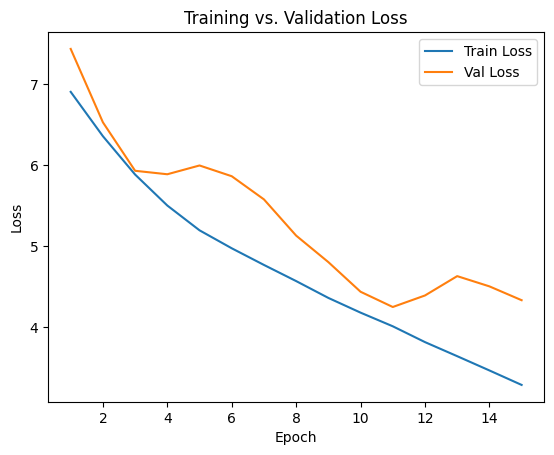

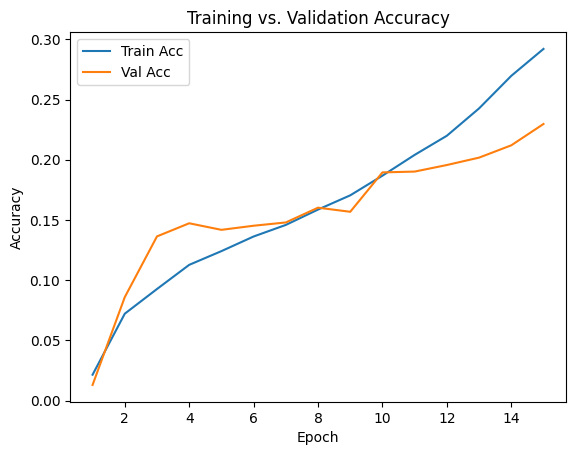

In [19]:
import matplotlib.pyplot as plt

# assume `history` is the History object from model.fit()

epochs = range(1, len(history.history['loss']) + 1)

# Loss
plt.figure()
plt.plot(epochs, history.history['loss'],      label='Train Loss')
plt.plot(epochs, history.history['val_loss'],  label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.show()

# Accuracy
plt.figure()
plt.plot(epochs, history.history['accuracy'],      label='Train Acc')
plt.plot(epochs, history.history.get('val_accuracy', []), label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()
plt.show()
